In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
from keras.models import load_model

model = load_model('ECG_cnn.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [4]:
base_path = "ecg_images"
test_dir = os.path.join(base_path, 'test')

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

testing_datagen = ImageDataGenerator(rescale=1./255)
test_generator = testing_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        color_mode = "grayscale", 
        batch_size=20,
        class_mode='categorical',
        shuffle = False)

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 535)
test_accuracy = test_acc*100
print('test accuracy: %.2f percent' %(test_accuracy))
print('test loss: %.2f' %(test_loss))

predictions = model.predict_generator(
    test_generator, 
    steps = np.math.ceil(test_generator.samples/ test_generator.batch_size))

predicted_classes = np.argmax(predictions, axis = 1).astype('int')

true_classes = test_generator.classes 
class_labels = list(test_generator.class_indices.keys())

Found 10825 images belonging to 11 classes.
test accuracy: 99.05 percent
test loss: 0.05


In [6]:
report = classification_report(true_classes, predicted_classes, target_names = ['A','a','E','!','L','N','/','R',
                                                                               'V','j','x'], digits = 3)
print(report)

              precision    recall  f1-score   support

           A      0.932     0.863     0.896       255
           a      0.889     0.533     0.667        15
           E      1.000     0.909     0.952        11
           !      0.902     0.958     0.929        48
           L      0.998     0.993     0.995       808
           N      0.992     0.996     0.994      7503
           /      1.000     0.999     0.999       703
           R      0.989     0.996     0.992       726
           V      0.989     0.971     0.979       713
           j      0.870     0.870     0.870        23
           x      0.900     0.900     0.900        20

   micro avg      0.990     0.990     0.990     10825
   macro avg      0.951     0.908     0.925     10825
weighted avg      0.990     0.990     0.990     10825



In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.9900230946882217


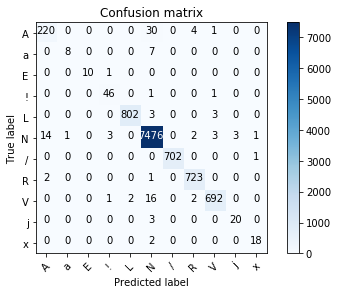

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools

# compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['A','a','E','!','L','N','/','R','V','j','x']) 
print(accuracy_score(true_classes, predicted_classes))

In [9]:
import pandas as pd

filenames = test_generator.filenames
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
results = pd.DataFrame({"Filename": filenames,
                        "True Class": [labels[k] for k in true_classes],
                        "Predicted Class": [labels[k] for k in predicted_classes]})

In [10]:
incorrects = results.loc[results['Predicted Class'] != results['True Class']]
corrects = results.loc[results['Predicted Class'] == results['True Class']]

In [11]:
len(incorrects.index)

108

In [12]:
incorrects[incorrects['Predicted Class'] == 'j']

,Filename,True Class,Predicted Class
4331,N\N43842.jpg,N,j
7846,N\N90440.jpg,N,j
7884,N\N90961.jpg,N,j


In [13]:
incorrects[incorrects['True Class'] == 'j']

,Filename,True Class,Predicted Class
10782,j\j45782.jpg,j,N
10784,j\j90514.jpg,j,N
10788,j\j90822.jpg,j,N


In [14]:
corrects[corrects['True Class'] == 'j'].head()

,Filename,True Class,Predicted Class
10783,j\j90391.jpg,j,j
10785,j\j90721.jpg,j,j
10786,j\j90739.jpg,j,j
10787,j\j90743.jpg,j,j
10789,j\j90852.jpg,j,j


In [15]:
corrects[corrects['True Class'] == 'N'].head()

,Filename,True Class,Predicted Class
1137,N\N10018.jpg,N,N
1138,N\N100186.jpg,N,N
1139,N\N100192.jpg,N,N
1140,N\N100194.jpg,N,N
1141,N\N100215.jpg,N,N


In [16]:
from keras.preprocessing import image

def show_image(name, true, predicted):
    img = image.load_img(name)
    plt.imshow(img)
    plt.title('True %s, Predicted %s' %(true,predicted), fontsize=16)
    plt.xticks([])
    plt.yticks([])
    
def show_image_file(name):
    path = os.path.join(base_path, name)
    img = image.load_img(path)
    plt.imshow(img)
    plt.title(name,fontsize=16)
    plt.xticks([])
    plt.yticks([])

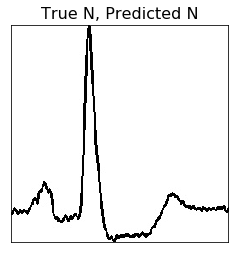

In [17]:
show_image('ecg_images/N/N10018.jpg', 'N', 'N')

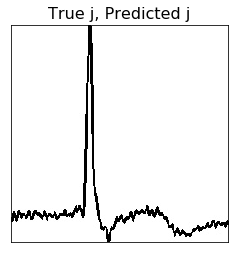

In [18]:
show_image('ecg_images/j/j90391.jpg', 'j', 'j')

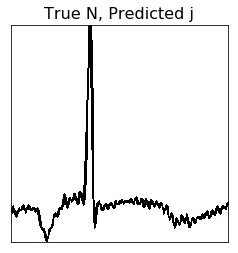

In [19]:
show_image('ecg_images/N/N90440.jpg', 'N', 'j')

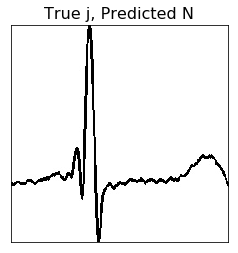

In [20]:
show_image('ecg_images/j/j45782.jpg', 'j', 'N')

Look at this to understand the j beat type (junctional escape beat): http://www.rnceus.com/ekg/ekgjeb.html 

In [21]:
results =  pd.read_csv('results.csv')

In [22]:
results

,Type,Precision,Recall,Support
0,A,0.924,0.859,255
1,a,0.846,0.733,15
2,E,1.000,0.909,11
3,!,0.917,0.917,48
4,L,0.999,0.993,808
5,N,0.992,0.996,7503
6,/,1.000,0.999,703
7,R,0.992,0.996,726
8,V,0.983,0.975,713
9,j,0.895,0.739,23


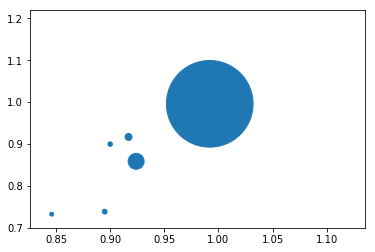

In [23]:
plt.scatter(results['Precision'],results['Recall'],s=results['Support'])

In [24]:
df2 = results[results.Type != 'N']

In [25]:
df2

,Type,Precision,Recall,Support
0,A,0.924,0.859,255
1,a,0.846,0.733,15
2,E,1.000,0.909,11
3,!,0.917,0.917,48
4,L,0.999,0.993,808
6,/,1.000,0.999,703
7,R,0.992,0.996,726
8,V,0.983,0.975,713
9,j,0.895,0.739,23
10,x,0.900,0.900,20


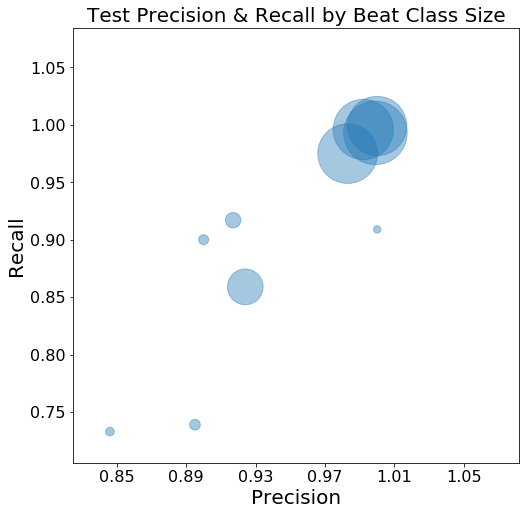

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(df2['Precision'],df2['Recall'],s=df2['Support']*5,alpha = 0.4)
plt.title('Test Precision & Recall by Beat Class Size',fontsize=20)
plt.xlabel('Precision',fontsize=20)
plt.ylabel('Recall',fontsize=20)
plt.xticks(np.linspace(.85,1.05,6),fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [27]:
corrects[corrects['True Class'] == 'A'].head()

,Filename,True Class,Predicted Class
0,A\A100654.jpg,A,A
1,A\A100667.jpg,A,A
2,A\A100668.jpg,A,A
3,A\A100669.jpg,A,A
4,A\A100686.jpg,A,A


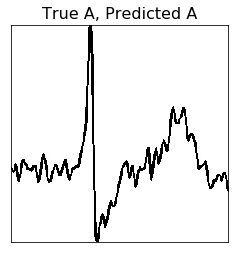

In [28]:
show_image('ecg_images/A/A100686.jpg', 'A', 'A')

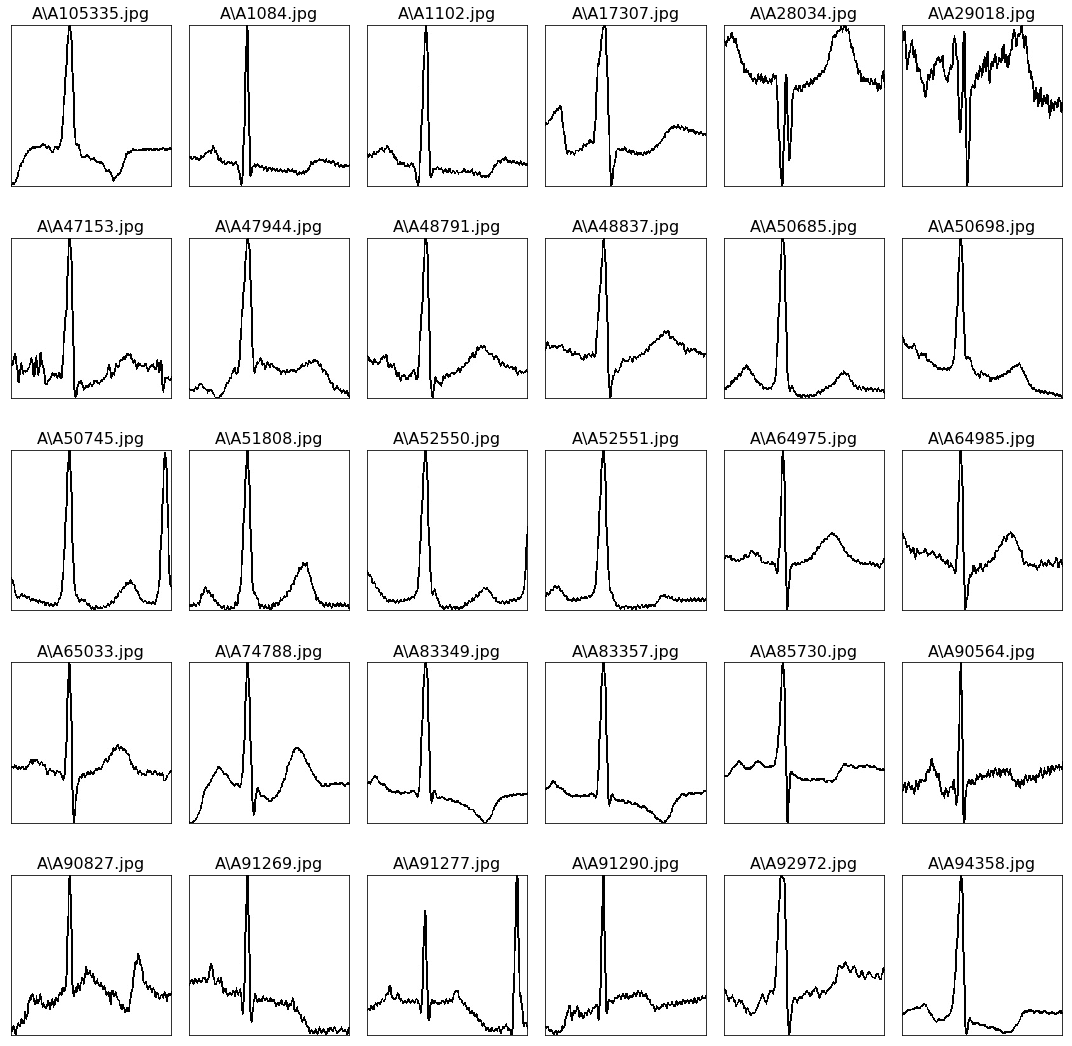

In [29]:
# Display true A, predicted N

A_N = incorrects[(incorrects['True Class'] == 'A') & (incorrects['Predicted Class'] == 'N')]

plt.figure(figsize=(15,15))

j = 1

for i in A_N['Filename']:
    plt.subplot(5,6,j)
    show_image_file(i)
    j += 1

plt.tight_layout()

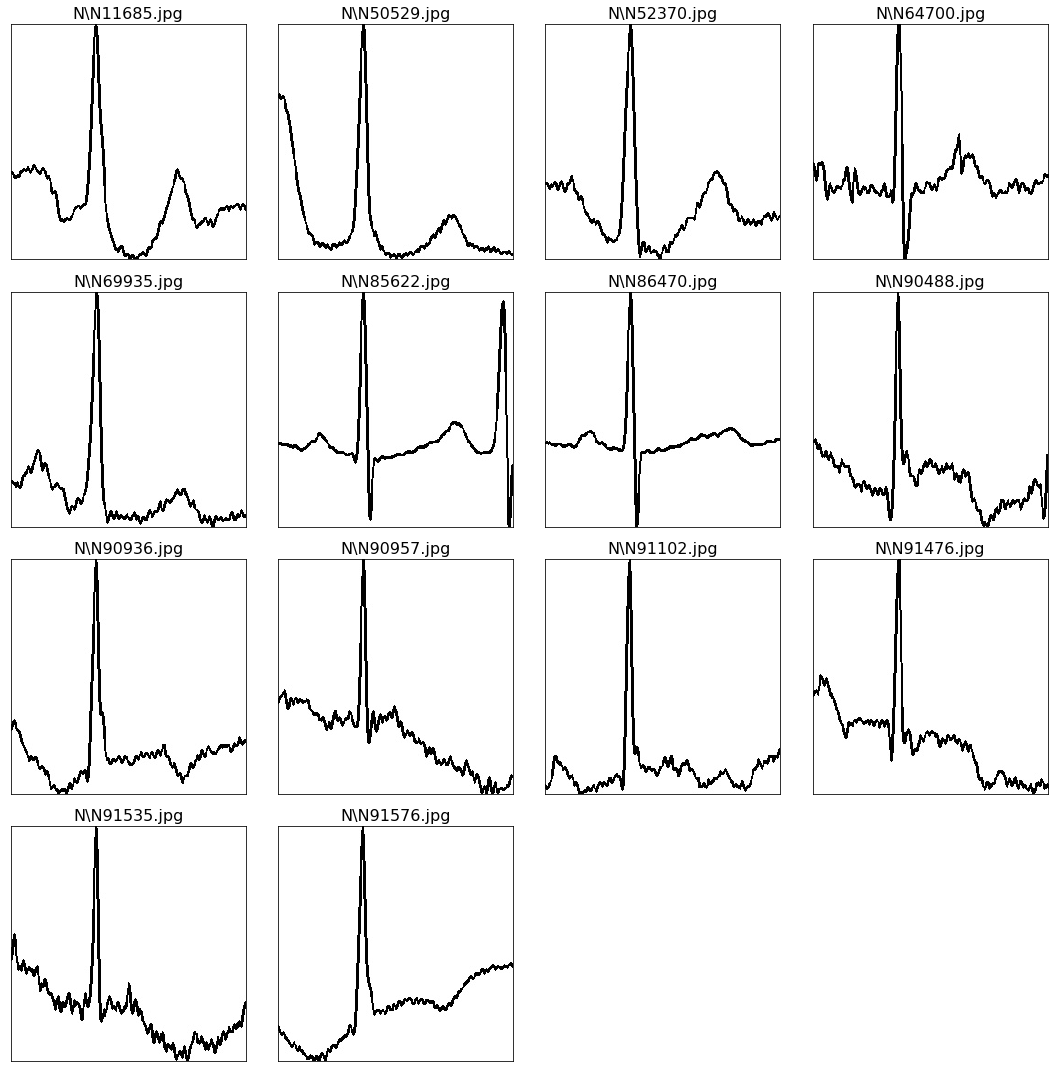

In [30]:
# Display true N, predicted A

N_A = incorrects[(incorrects['True Class'] == 'N') & (incorrects['Predicted Class'] == 'A')]

plt.figure(figsize=(15,15))

j = 1

for i in N_A['Filename']:
    plt.subplot(4,4,j)
    show_image_file(i)
    j += 1

plt.tight_layout()

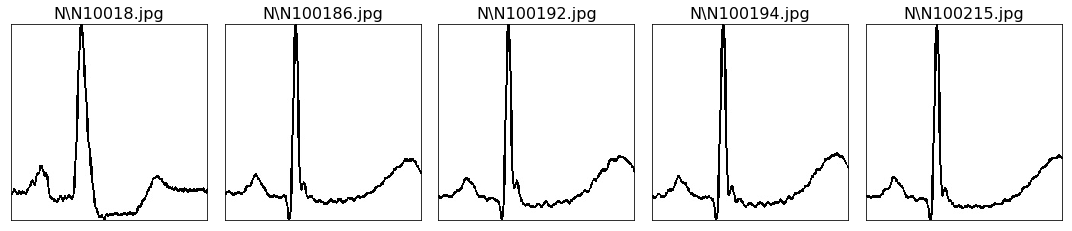

In [31]:
# Display true N

True_N = corrects[corrects['True Class'] == 'N'].head()

plt.figure(figsize=(15,15))

j = 1

for i in True_N['Filename']:
    plt.subplot(1,5,j)
    show_image_file(i)
    j += 1

plt.tight_layout()

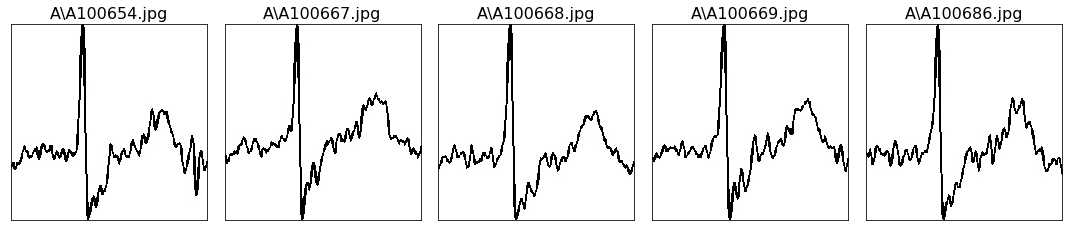

In [32]:
# Display true A, predicted A

True_A = corrects[corrects['True Class'] == 'A'].head()

plt.figure(figsize=(15,15))

j = 1

for i in True_A['Filename']:
    plt.subplot(1,5,j)
    show_image_file(i)
    j += 1

plt.tight_layout()

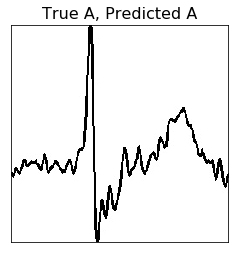

In [47]:
show_image('ecg_images/A/A100669.jpg', 'A', 'A')

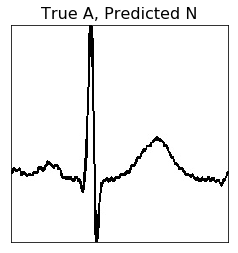

In [59]:
show_image('ecg_images/A/A64975.jpg', 'A', 'N')

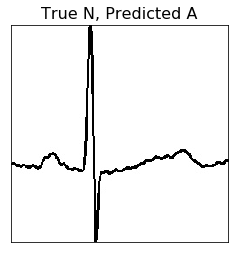

In [49]:
show_image('ecg_images/N/N86470.jpg', 'N', 'A')

In [51]:
corrects[corrects['True Class'] == 'A']

,Filename,True Class,Predicted Class
0,A\A100654.jpg,A,A
1,A\A100667.jpg,A,A
2,A\A100668.jpg,A,A
3,A\A100669.jpg,A,A
4,A\A100686.jpg,A,A
5,A\A100688.jpg,A,A
6,A\A100697.jpg,A,A
7,A\A100703.jpg,A,A
8,A\A100714.jpg,A,A
9,A\A100720.jpg,A,A


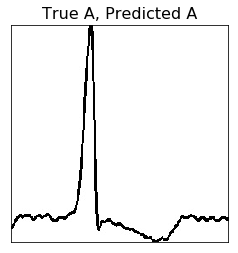

In [58]:
show_image('ecg_images/A/A92689.jpg','A','A')